In [1]:
import torch
import torchvision
from matplotlib import pyplot
from keras.datasets import cifar10
import numpy as np
import librosa
from librosa import display
from PIL import Image
from matplotlib import pyplot
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import cmath
import seaborn as sns
import scipy
import IPython.display as ipd
import math
from numpy.linalg import inv
import torch 
import torchvision
from torchvision import datasets
import numpy as np
import time
import numpy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import random
device = torch.device("cuda") 

## Preparing Dataset

In [2]:
device = torch.device("cuda") 
(trainX, trainy), (testX, testy) = cifar10.load_data()

trainX_pretext=trainX[0:49500]
trainy_pretext=trainy[0:49500]

trainX_baseline=trainX[49500:50000]
trainy_baseline=trainy[49500:50000]


testX_valid=testX[0:10000]
testy_valid=testy[0:10000]

## Function for Standardizing Dataset

In [3]:
def function_std(input):
  new_input= (input-0.5)/0.5
  return new_input

## Function for changing the data into desired input (Channels x Height X Width)

In [4]:
def change_into_channels(input):
  num1=[]
  for k in range(len(input)):
    num2=[]
    for j in range(3):
      num2.append(input[k][:,:,j])
    num1.append(num2)
  return num1

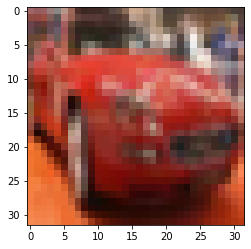

In [5]:
plt.imshow(trainX_pretext[5])

## Vertically Flipping Image

In [6]:
vertically_flipping=[]
for i in trainX_pretext:
  vertically_flipping.append(numpy.flipud(i))

## Rotating_Images_90_degree_clockwise

In [7]:
rotate90clockwise=[]
for i in trainX_pretext:
  rotate90clockwise.append(np.rot90(i))

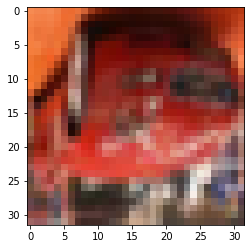

In [8]:
plt.imshow(vertically_flipping[5])

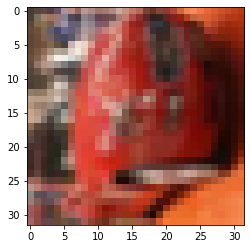

In [9]:
plt.imshow(rotate90clockwise[5])

## Concatenating Dataset and creating pretext train data

In [10]:
pretext_data=np.concatenate((trainX_pretext,vertically_flipping,rotate90clockwise),0)

## Creating Labels for Pretext Data 

In [11]:
pretext_y=np.concatenate(([0]*49500,[1]*49500,[2]*49500),0)

## Function for normalizing and standardizing and converting the data into Channels x Length X Width

In [12]:
def data_manipulation_pretext(train_X):
  valid_norm= np.array(train_X)/255
  valid_norm_standardized=function_std(valid_norm)
  conver_validX= change_into_channels(valid_norm_standardized)
  return conver_validX
  

## Pretext Final Data to be Trained

In [13]:
pretext_data_final= data_manipulation_pretext(pretext_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


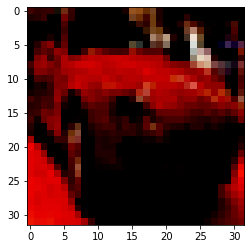

In [14]:
plt.imshow(np.transpose(pretext_data_final[5], (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


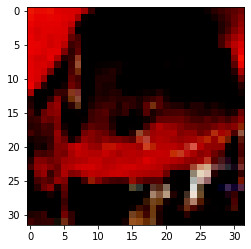

In [15]:
plt.imshow(np.transpose(pretext_data_final[49505], (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


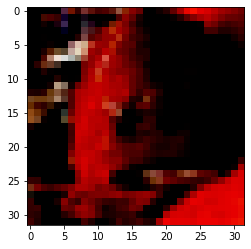

In [16]:
plt.imshow(np.transpose(pretext_data_final[99005], (1,2,0)))

## Zipping the pretext data and labels and shuffling them 

In [17]:
gh= list(zip(pretext_data_final,pretext_y))
random.shuffle(gh)

## Unzipping the shuffled data 

In [18]:
input_im=[]
input_label=[]
for i , (im ,lb) in enumerate(gh):

  input_im.append(im) ## contains the images
  input_label.append(lb) ## contains the labels

In [19]:
print(np.shape(input_im))

(148500, 3, 32, 32)


## Pretext Model

In [20]:
class Pretext(nn.Module):
    def __init__(self):
        super(Pretext, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10,  kernel_size=5, stride=1)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, stride=1)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.layer3 = torch.nn.Linear(5*5*10, 20)
        torch.nn.init.kaiming_normal_(self.layer3.weight)
        self.layer4=torch.nn.Linear(20, 3)
        torch.nn.init.kaiming_normal_(self.layer4.weight)
        self.act=nn.ReLU()

    def forward(self, x):
        out1 = self.act(self.conv1(x))
        out2 = self.pool1(out1)
        out3 = self.act(self.conv2(out2))
        out4 = self.pool2(out3)
        out5 = out4.reshape(out4.size(0), out4.size(1)*out4.size(2)*out4.size(3))
        out6 = self.act(self.layer3(out5))
        out7 = self.layer4(out6)
        return out7

## Function for calculating Accuracy

In [21]:
def accuracy(model,test_X,test_Y): ## model, test data, test labels as input

  with torch.no_grad():
      correct = 0
      total = 0
    
      labels = test_Y.cuda()
      outputs = model(test_X).cuda()
      # print(outputs,"outputs")
      # print(torch.max(outputs.data, 1),"max")
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      # print(labels.size(0),"labels size")
      # print(predicted,"predicted")

      # print(labels,"labels")

      correct += (predicted == labels).sum().item()
      accuracy =100 * correct / total
  return accuracy

## Initializing the Pretext_model

In [22]:
Pretext_model = Pretext().cuda()

## Pretext_model_function 

We have taken a batch size of 300 and cross entropy loss function to calculate the weights of the model based on the architecture described above 

In [23]:
def function_pretext(model,input,train):
  
  input1= torch.FloatTensor(input).cuda()
  train1=torch.tensor(train).type(torch.LongTensor).cuda()

  accuracy1=[]

  criterion = torch.nn.CrossEntropyLoss()
  
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  errt=[0 for i in range(100)]
  for epoch in range(100):
      running_loss=0
      for k in range(int(len(input1)/300)):
          images=input1[300*k:300*(k+1)] 
          labels= train1[300*k:300*(k+1)]

          
          # Move tensors to the configured device
          # images1= torch.FloatTensor(images).cuda()


          # Forward pass
          outputs =model(images).cuda()
          
          loss = criterion(outputs.cuda(), labels.cuda())
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss+=loss.item()
      
      errt[epoch]=running_loss/(k+1)
      accuracy_c=accuracy(model,images,labels)
      accuracy1.append(accuracy_c)
      print("Epoch:", epoch,"Loss:",running_loss/(k+1),"accuracy:",accuracy_c)
  return errt,accuracy1

In [ ]:
new_model_pretext_error= function_pretext(Pretext_model,input_im,input_label)

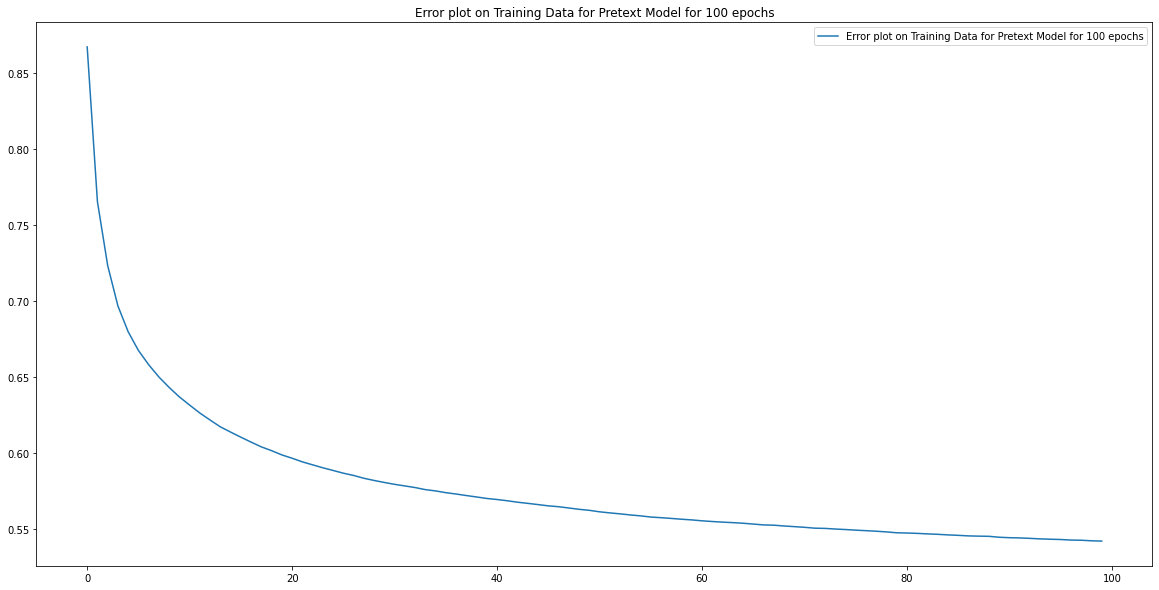

In [25]:
plt.figure(figsize=(20,10))
plt.plot(new_model_pretext_error[0],label="Error plot on Training Data for Pretext Model for 100 epochs")
plt.legend()
plt.title('Error plot on Training Data for Pretext Model for 100 epochs')
plt.show()

## Weights of Pretext Model after Training

In [26]:
for param_tensor in Pretext_model.state_dict():
  print(param_tensor, "\t", Pretext_model.state_dict()[param_tensor])

conv1.weight 	 tensor([[[[-2.1323e-01,  3.2313e-01, -5.8674e-01, -2.7880e-02, -2.3479e-01],
          [ 5.7846e-02, -3.6354e-01, -5.8485e-01, -1.5690e-01, -2.4723e-01],
          [-4.0160e-02,  1.0879e-01, -3.2271e-01,  2.8756e-02, -1.7859e-01],
          [ 6.0092e-02,  3.9359e-01,  2.9428e-01,  5.5978e-02,  9.7662e-02],
          [ 3.1798e-01,  1.7798e-01, -3.3139e-02, -7.4776e-02, -4.6524e-01]],

         [[-1.6506e-01, -9.6327e-02, -3.8114e-01,  1.3293e-01,  4.9756e-01],
          [-7.9798e-02,  1.7202e-01, -2.4154e-01,  1.3682e-01,  1.1442e-01],
          [-4.3182e-01, -3.7511e-01, -1.5951e-01,  3.1278e-01,  4.1241e-01],
          [ 5.7322e-02, -1.3807e-01, -2.0789e-01, -1.7485e-02,  7.9063e-02],
          [ 1.8715e-02,  2.1047e-01, -1.7084e-01, -1.1639e-01,  4.8483e-01]],

         [[ 3.2949e-01,  3.9364e-01,  5.7335e-01,  1.8290e-01,  2.3392e-01],
          [ 9.8332e-02,  3.2808e-01,  2.5170e-01, -1.3674e-01, -1.7231e-01],
          [ 4.6086e-01,  4.5142e-01,  4.5571e-02,  5.3942

## Baseline Model Creation

In [27]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10,  kernel_size=5, stride=1)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, stride=1)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.layer3 = torch.nn.Linear(5*5*10, 20)
        torch.nn.init.kaiming_normal_(self.layer3.weight)
        self.layer4=torch.nn.Linear(20, 10)
        torch.nn.init.kaiming_normal_(self.layer4.weight)
        self.act=nn.ReLU()

    def forward(self, x):
        out1 = self.act(self.conv1(x))
        out2 = self.pool1(out1)
        out3 = self.act(self.conv2(out2))
        out4 = self.pool2(out3)
        out5 = out4.reshape(out4.size(0), out4.size(1)*out4.size(2)*out4.size(3))
        out6 = self.act(self.layer3(out5))
        out7 = self.layer4(out6)
        return out7

## Standardizing and Normalizing the baseline train data 

In [28]:
train_X_baseline_final= data_manipulation_pretext(trainX_baseline)
train_Y_baseline_final= trainy_baseline.flatten()

## Image before standardizing for baseline train data

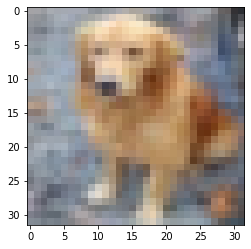

In [29]:
plt.imshow(trainX_baseline[8])

## Image after standardizing for baseline train data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


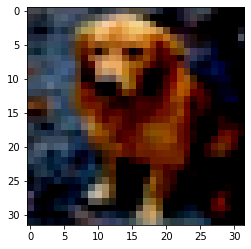

In [30]:
plt.imshow(np.transpose(train_X_baseline_final[8], (1,2,0)))

## Standardizing the validation dataset and creating the dataset that the model will be validated on

In [31]:
test_X_baseline_final=data_manipulation_pretext(testX_valid)
test_Y_baseline_final=testy_valid.flatten()

## Image before standardizing for baseline test data

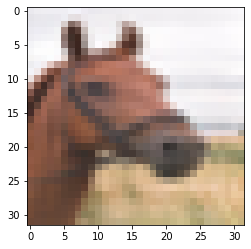

In [32]:
plt.imshow(testX_valid[99])

## Image after standardizing for baseline train data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


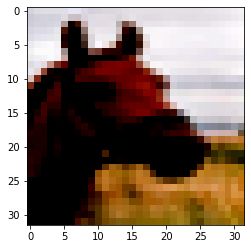

In [33]:
plt.imshow(np.transpose(test_X_baseline_final[99], (1,2,0)))

## Initializing the Baseline_Model

In [34]:
Baseline_model=Baseline().cuda()

## Creating Baseline Function

We have used a batch size of 500 as the training dataset contains 500 samples only

In [35]:
def function_for_cal_baseline(model,input,train,validation_X,validation_Y): ## model name, input train X, input train Y, validation X and validation Y 
  
  validation_X1=torch.FloatTensor(validation_X).cuda()
  validation_Y1=torch.tensor(validation_Y).type(torch.LongTensor).cuda()
  input1= torch.FloatTensor(input).cuda()
  train1=torch.tensor(train).type(torch.LongTensor).cuda()

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  errt=[0 for i in range(10000)]
  validation_accuracy=[]
  test_accuracy=[]
  for epoch in range(10000):
      running_loss=0
      for j in range(int(len(input1)/500)):
          # Move tensors to the configured device
      
          images= input1[j*500:(j+1)*500]
          labels= train1[j*500:(j+1)*500]
          
          # Forward pass
          outputs = model(images.cuda()).cuda()
          
          loss = criterion(outputs.cuda(), labels.cuda())
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss+=loss.item()
      
      errt[epoch]=running_loss*(500/len(input1))

      valida= accuracy(model,validation_X1,validation_Y1)
      # testa=accuracy(net,testX_set,testY_set)
      validation_accuracy.append(valida)
    
      if epoch%100==0:
        print("Epoch:", epoch,"Loss:",running_loss*(500/len(input1)),"validation accuracy:",valida)

  return validation_accuracy,errt

In [ ]:
Baseline_model_run= function_for_cal_baseline(Baseline_model,train_X_baseline_final,train_Y_baseline_final,test_X_baseline_final,test_Y_baseline_final)

## Creating Finetuning Model

In [37]:
class Finetuning(nn.Module):
    def __init__(self):
        super(Finetuning, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10,  kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.layer3 = torch.nn.Linear(5*5*10, 20)
        self.layer4=torch.nn.Linear(20, 10)
        self.act=nn.ReLU()

    def forward(self, x):
        out1 = self.act(self.conv1(x))
        out2 = self.pool1(out1)
        out3 = self.act(self.conv2(out2))
        out4 = self.pool2(out3)
        out5 = out4.reshape(out4.size(0), out4.size(1)*out4.size(2)*out4.size(3))
        out6 = self.act(self.layer3(out5))
        out7 = self.layer4(out6)
        return out7

In [38]:
finetuning_model=Finetuning().cuda()

##  Transferring the weights from Pretext Model to  Baseline Model

In [40]:
pretext_model_assigned=Pretext_model.state_dict()
pretext_model_assigned["layer4.weight"]=torch.nn.init.kaiming_normal_(torch.empty(10,20))
pretext_model_assigned["layer4.bias"]=torch.zeros(10)

In [41]:
finetuning_model.load_state_dict(pretext_model_assigned)

<All keys matched successfully>

## FineTuning Model Calculation

We have used a batch size of 500 as the training samples are 500 and different learning rate for different layers. we have used 1e-5 as learning for all the layers except the last layer where we have used a learning rate of 1e-3

In [42]:
def function_for_cal_finetuning(model,input,train,validation_X,validation_Y):
  
  validation_X1=torch.FloatTensor(validation_X).cuda()
  validation_Y1=torch.tensor(validation_Y).type(torch.LongTensor).cuda()
  input1= torch.FloatTensor(input).cuda()
  train1=torch.tensor(train).type(torch.LongTensor).cuda()

  criterion = torch.nn.CrossEntropyLoss()
  optimizer  = torch.optim.Adam(
    [
        {"params": model.conv1.parameters(), "lr": 1e-5},
        {"params": model.conv2.parameters(),"lr": 1e-5},
        {"params": model.layer3.parameters(), "lr": 1e-5},
        {"params": model.layer4.parameters(), "lr": 0.001}

    ]
)
  errt=[0 for i in range(10000)]
  validation_accuracy=[]
  test_accuracy=[]
  for epoch in range(10000):
      running_loss=0
      for j in range(int(len(input1)/500)):
          # Move tensors to the configured device
      
          images= input1[j*500:(j+1)*500]
          labels= train1[j*500:(j+1)*500]
          
          # Forward pass
          outputs = model(images.cuda()).cuda()
          
          loss = criterion(outputs.cuda(), labels.cuda())
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          running_loss+=loss.item()
      
      errt[epoch]=running_loss*(500/len(input1))

      valida= accuracy(model,validation_X1,validation_Y1)
      # testa=accuracy(net,testX_set,testY_set)
      validation_accuracy.append(valida)
    
      if epoch%100==0:
        print("Epoch:", epoch,"Loss:",running_loss*(500/len(input1)),"validation accuracy:",valida)

  return validation_accuracy,errt

In [ ]:
Finetuning_model_run= function_for_cal_finetuning(finetuning_model,train_X_baseline_final,train_Y_baseline_final,test_X_baseline_final,test_Y_baseline_final)

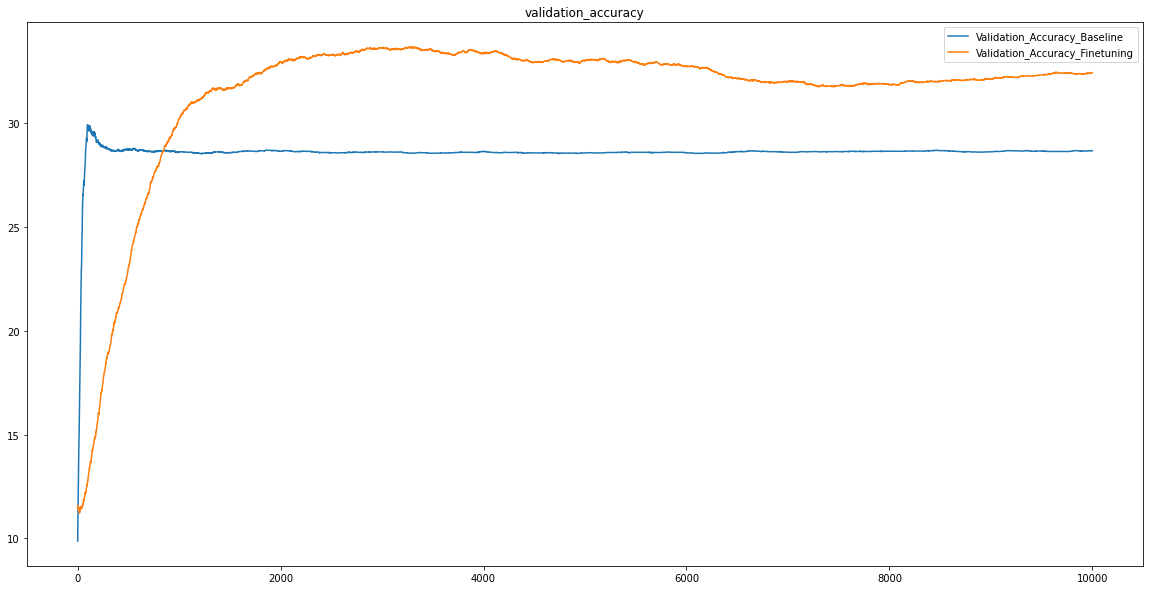

In [44]:
plt.figure(figsize=(20,10))
plt.plot(Baseline_model_run[0],label="Validation_Accuracy_Baseline")
plt.plot(Finetuning_model_run[0],label="Validation_Accuracy_Finetuning")
plt.legend()
plt.title('validation_accuracy')
plt.show()